# Advanced Machine Learning - programming assignment 4

*Due: Friday January 26*

**Please fill in:**
* Ingólfur Ari Jóhannsson (2431475)
* Nikos Lazaridis (7496974)

### Further instructions:
* Code quality is considered during the assessment. Use sensible variable names, and make sure your code is properly commented.
* Submit your code in Blackboard using one of your accounts; we will put the grade in Blackboard for the other team member as well.
* Make sure to name the submitted file according to your and your collaborators last name. (`submitter_collaborator.ipynb`)
* **Failure to follow these instructions can affect the assignment grade.**

## Implementing the PC algorithm
In this assignment, you will complete an implementation of the PC algorithm. After that, you will use it to discover causal relations in a data set. Each of these two parts is worth 5 points.

The PC algorithm will need to keep track of a PDAG. We will represent this PDAG by a numpy array `G` of booleans.

The matrix `G` represents a graph as follows:
* For all `x`, `G[x,x] == False`
* `G[x,y] == False` and `G[y,x] == False` means: no edge between x and y
* `G[x,y] == True` and `G[y,x] == True` means: an undirected edge x&mdash;y
* `G[x,y] == True` and `G[y,x] == False`means: a directed edge x $\to$ y

In [32]:
import numpy as np
import itertools
import graphviz # Install with: conda install python-graphviz
from itertools import combinations
from AML_assignment4_util import *

The graphviz package can draw graphs to different file formats, or show them directly in the notebook. The function `graph_to_graphviz(G, node_names)` (from the file `AML_assignment4_util.py`) converts a numpy array of the form described above to a graph in graphviz format. 

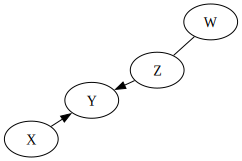

In [33]:
# Demonstration of graph_to_graphviz:
node_names = ['X', 'Y', 'Z', 'W']
G1 = np.zeros((4,4), dtype=bool)
G1[0,1] = G1[2,1] = True # two directed edges
G1[2,3] = G1[3,2] = True # an undirected edge
d = graph_to_graphviz(G1, node_names)
d # must be final line of code block to be displayed

Here is a Python class for performing the PC algorithm (when an object of this class is created and its `run` function is called). Add the missing code for phase 2, and implement phases 3 and 4. In the next section, you'll find some test cases to see if your code runs without errors and does what you expect it to.

In [34]:
class PC_algorithm:
    def __init__(self, independence_tester, verbose=1):
        # verbose can be 0 (silent), 1 (report independences), or 2 (also report dependences)
        self.independence_tester = independence_tester
        self.n = independence_tester.n_observed
        self.node_names = independence_tester.node_names
        self.verbose = verbose
        self.G = np.logical_not(np.eye(self.n, dtype=bool))
        self.sepset = dict()

    def list_S(self, given_k, given_x, given_y, given_G):
        S = []
        for node in range(given_G.shape[0]):
            if given_G[node, given_x]:
                if node!=given_y:
                    S.append(node)
                
        return itertools.combinations(S,given_k)    
    
    def skeleton_search(self):
        # PHASE II: Skeleton search
        # Note: Adj(X) in the slides means: all nodes adjacent to X in the current graph G
        for k in range(self.n-1):
            for x in range(self.n):
                for y in range(self.n):
                    if not self.G[x,y]:
                        continue
                    # Try all subsets S of Adj(x) \ {y} with |S|=k,
                    # until an independence is found.
                    # Hint: use itertools.combinations

                    # Your code here (1 point)

                    for S in self.list_S(k, x, y, self.G): # replace this line by your code
                        indep = self.independence_tester.test_independence(x, y, S)
                        if indep:
                            if self.verbose >= 1:
                                print("independence found: {0} and {1} given {{{2}}}"
                                      .format(self.node_names[x], self.node_names[y],
                                              ", ".join([self.node_names[v] for v in S])))
                            # Remove this edge.
                            self.G[x,y] = self.G[y,x] = False
                            # We use frozensets as keys in the dictionary self.sepset,
                            # because ordinary sets can't be used as keys to dictionaries.
                            self.sepset[frozenset([x,y])] = S
                            break
                        else:
                            if self.verbose >= 2:
                                print("dependence found: {0} and {1} given {{{2}}}"
                                      .format(self.node_names[x], self.node_names[y],
                                              ", ".join([self.node_names[v] for v in S])))

            # Do we need to continue with larger k?
            max_S_size = np.sum(self.G, axis=0) - 1
            if np.all(max_S_size < k + 1):
                break
        return

    def orient_v_structures(self):
        # PHASE III: Orient v-structures
        # Something to watch out for:
        # If the data are not faithful to any graph, the algorithm may end up trying
        # to orient a single edge in two different ways. You can choose either
        # orientation if this happens. But make sure not to accidentally delete such an edge!
        for x in range(self.n):
            for y in range(self.n):
                #not the same and adjacent
                if x!=y and not(self.G[x,y] or self.G[y,x]):
                    for z in range(self.n):
                        if (self.G[z,x] or self.G[x,z]) and (self.G[z,y] or self.G[y,z]):
                            if z in self.sepset[frozenset([x,y])]:
                                continue
                            else:
                                self.G[z,x] = self.G[z,y] = False
                                self.G[x,z] = self.G[y,z] = True

        # Your code here (2 points)
        return
    
    def orientation_rules(self):
        # PHASE IV: Orientation rules
        rule_1 = rule_2 = rule_3 = True
        while(np.any([rule_1,rule_2, rule_3])):
            if rule_1:
                rule_1 = self.rule1()
            if rule_2:
                rule_2 = self.rule2()
            if rule_3:
                rule_3 = self.rule3()
        return
    
    def directed(self,x,y):
        # tests if two nodes have a single direction
        return self.G[x,y] and not self.G[y,x]

    def bidirectional(self, x, y):
        # tests if two nodes are pointing at each other
        return self.G[x,y] and self.G[y,x]

    def adjacent(self, x, y):
        # tests if two nodes are share an edge
        return self.G[x,y] or self.G[y,x]
    
    def add_directed(self, x, y):
        # removes one direction of a bidirectional edge
        self.G[y,x] = False

    def is_any_equal(self, nodes):
        for (x,y) in combinations(nodes, 2):
            if x == y: return True
        return False

    def rule1(self):
        for current_node in range(self.n):
            for other_node in range(self.n):
                if current_node == other_node:
                    continue
                if self.bidirectional(current_node, other_node):
                    for possible_parent in range(self.n):
                        if (possible_parent != other_node) and \
                                self.directed(possible_parent, current_node) and \
                                not self.adjacent(possible_parent, other_node):
                            self.add_directed(current_node, other_node)
                            return True
        return False

    def rule2(self):
        for current_node in range(self.n):
            for other_node in range(self.n):
                if current_node == other_node:
                    continue
                if self.bidirectional(current_node, other_node):
                    for possible_child in range(self.n):
                        if (possible_child != other_node) and \
                                self.adjacent(current_node, possible_child) and \
                                self.directed(current_node, possible_child) and \
                                self.directed(possible_child, other_node):
                            self.add_directed(current_node, other_node)
                            return True
        return False

    def rule3(self):
        bidir_list = []

        for current_node in range(self.n):
            for other_node in range(self.n):
                if current_node == other_node:
                    continue
                if self.bidirectional(current_node, other_node):
                    bidir_list.append(other_node)
                    if len(bidir_list) == 3:
                        # We've got enough nodes to apply the rule
                        node_to_change = False
                        if      self.directed(bidir_list[1], bidir_list[0]) and \
                                self.directed(bidir_list[2], bidir_list[0]) and \
                                not self.adjacent(bidir_list[1],bidir_list[2]):
                            node_to_change = bidir_list[0]
                        elif    self.directed(bidir_list[0], bidir_list[1]) and \
                                self.directed(bidir_list[2], bidir_list[1]) and \
                                not self.adjacent(bidir_list[0],bidir_list[2]):
                            node_to_change = bidir_list[1]
                        elif    self.directed(bidir_list[1], bidir_list[2]) and \
                                self.directed(bidir_list[0], bidir_list[2]) and \
                                not self.adjacent(bidir_list[1],bidir_list[0]):
                            node_to_change = bidir_list[2]
                        bidir_list = []
                        if node_to_change:
                            self.add_directed(current_node, other_node)
                            return True
            bidir_list = []
        return False
                        


    def run(self):
        # The initialization step has already been performed by the __init__ method.
        # Perform the other phases one by one. Each of the following functions
        # modifies self.G, which represents the graph.
        self.skeleton_search()
        self.orient_v_structures()
        self.orientation_rules()

        return self.G

## Testing the PC implementation

To verify that the algorithm is working correctly, we will feed it output from an *oracle* instead of conditional independence test results from a data set. The oracle knows what the true graph is, and mimics the conditional independence test results that we would get for data that is Markov and faithful to that graph. In this situation, the PC algorithm will recover the Markov equivalence class of the true graph.

In [35]:
class IndependenceOracle:
    def __init__(self, true_G, node_names, n_observed=None):
        self.G = true_G
        self.n = true_G.shape[0]
        self.n_observed = n_observed if n_observed is not None else self.n
        self.node_names = node_names
    def test_independence(self, x, y, S):
        S_mask = np.zeros(self.n, dtype=bool)
        np.put(S_mask, S, True)
        return is_d_separated(self.G, x, y, S_mask)

We will compare the output of PC to the oracle's true graph for the graph `G1` we saw before, and for several other graphs. (You can add more tests to help chase down any bugs.)

dependence found: X and Y given {}
independence found: X and Z given {}
independence found: X and W given {}
dependence found: Y and X given {}
dependence found: Y and Z given {}
dependence found: Y and W given {}
dependence found: Z and Y given {}
dependence found: Z and W given {}
dependence found: W and Y given {}
dependence found: W and Z given {}
dependence found: Y and X given {Z}
dependence found: Y and X given {W}
dependence found: Y and Z given {X}
dependence found: Y and Z given {W}
dependence found: Y and W given {X}
independence found: Y and W given {Z}
dependence found: Z and Y given {W}
dependence found: Z and W given {Y}
PASS


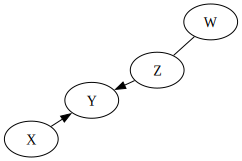

In [36]:
oracle = IndependenceOracle(G1, node_names)
A = PC_algorithm(oracle, verbose=2)
G = A.run()
print("PASS" if np.all(G == G1) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

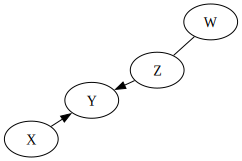

In [37]:
d = graph_to_graphviz(G, node_names)
d # must be final line of code block to be displayed

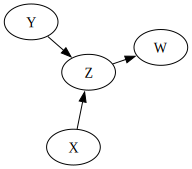

In [38]:
G2 = np.zeros((4,4), dtype=bool)
G2[0,2] = G2[1,2] = G2[2,3] = True
graph_to_graphviz(G2, node_names)

independence found: X and Y given {}
independence found: X and W given {Z}
independence found: Y and W given {Z}
PASS


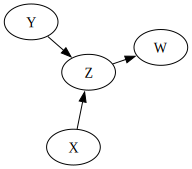

In [39]:
oracle = IndependenceOracle(G2, node_names)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if np.all(G == G2) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

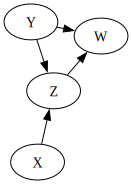

In [40]:
G3 = np.zeros((4,4), dtype=bool)
G3[0,2] = G3[1,2] = G3[1,3] = G3[2,3] = True
graph_to_graphviz(G3, node_names)

independence found: X and Y given {}
independence found: W and X given {Y, Z}
PASS


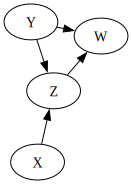

In [41]:
oracle = IndependenceOracle(G3, node_names)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if np.all(G == G3) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

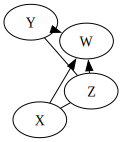

In [42]:
G4 = np.logical_not(np.eye(4, dtype=bool))
G4[0,1] = G4[1,0] = False
G4[3,0] = G4[3,1] = G4[3,2] = False
graph_to_graphviz(G4, node_names)

independence found: X and Y given {Z}
PASS


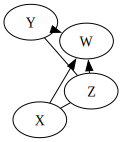

In [43]:
oracle = IndependenceOracle(G4, node_names)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if np.all(G == G4) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

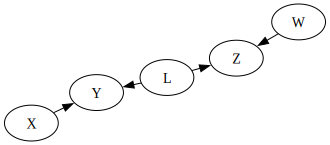

In [44]:
# Example of a case for which no DAG exists that is Markov and faithful to the distribution.
# L is a latent variable that the PC algorithm won't know about. PC's output should be either
# X --> Y --> Z <-- W or
# X --> Y <-- Z <-- W.
# If there is no edge between Y and Z in your output, this most likely indicates a bug in
# your implementation of phase III.
G5 = np.zeros((5,5), dtype=bool)
G5[0,1] = G5[4,1] = True
G5[3,2] = G5[4,2] = True
graph_to_graphviz(G5, ['X', 'Y', 'Z', 'W', 'L'])

independence found: X and Z given {}
independence found: X and W given {}
independence found: Y and W given {}
PASS


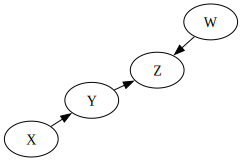

In [45]:
oracle = IndependenceOracle(G5, node_names, n_observed = 4)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if G[0,1] and G[3,2] and (G[1,2] or G[2,1]) and np.sum(np.logical_or(G, G.T)) == 6 else "FAIL")
graph_to_graphviz(G, oracle.node_names)

## Running PC on data
In this second part of the assignment, you will apply the PC algorithm to the biological dataset of Sachs et al. (2005). In this dataset, the columns represent 11 different proteins, which were measured in thousands of human immune system cells. Each row is a single cell. The cells were prepared in different ways, by adding different chemicals some time before the measurements were made. A twelfth column, labeled `experiment`, indicates in which way that cell was prepared. We can think of `experiment=1` as denoting the observational data, and other values of `experiment` (2 through 14) as various interventional datasets.

In [46]:
import pandas as pd

all_data = pd.read_csv("sachs2005_combined.csv", sep='\t')
# Transform all columns except 'experiment' by taking the logarithm of 10 + the original value
all_data.loc[:, all_data.columns != 'experiment'] = np.log(10 + all_data.loc[:, all_data.columns != 'experiment'])

We will apply the PC algorithm to just the observational data.

Make a new dataframe containing only the data where experiment equals 1. Remove the `experiment` column from this dataframe. Check the shape of your dataframe: it should be `(853, 11)`.

In [47]:
# Your code here (0.5 point)
exp1 = all_data[all_data['experiment'] == 1]
exp1 = exp1.drop('experiment', axis=1)
print(exp1.shape)

(853, 11)


To run the PC algorithm on data, we need to perform (conditional) independence tests. The code below implements a simple test (based on [partial correlation](https://en.wikipedia.org/wiki/Partial_correlation)). It assumes the data come from a linear structural causal model, which they actually don't. We will use it anyway, because the alternatives (such as `CMIknn` (Runge, 2018)) are orders of magnitude slower, while partial correlation usually already gives decent results.

As a statistical test, a conditional independence test works by computing a p-value. If a conditional independence exists, this p-value will be approximately uniformly distributed on the interval between 0 and 1. If the variables being tested are conditionally dependent, the p-value will be close to 0. PC wants to know a binary answer, so we will pick some threshold alpha and declare an independence if the p-value is larger than alpha.

In statistical testing, alpha is often taken to be 0.05 or smaller. For PC, it may be more appropriate to pick a larger alpha instead. This is because as soon as PC finds a (conditional) independence between two variables, it will delete the edge between them and do no more tests between those two variables. If this happens while it shouldn't have, PC can't put the edge back. But in the reverse situation, if PC leaves an edge in place while it should have deleted it, there is still a possibility that the edge will be deleted later, when another test between those two variables reports a more convincing independence.

In [48]:
import math
from scipy.stats import beta

class IndependenceTester:
    def __init__(self, data, alpha, verbose=2, n_observed=None):
        # data: a pandas dataframe
        # alpha: the significance level to which the p-values are compared
        
        self.covariance_matrix = np.cov(data, rowvar=False, bias=True)
        self.num_samples = data.shape[0]
        self.n = data.shape[1]
        self.n_observed = n_observed if n_observed is not None else self.n
        self.verbose = verbose
        self.node_names = data.columns
        self.alpha = alpha
    def test_independence(self, x, y, S):
        # Compute the partial correlation of x and y given S by inverting a submatrix of the covariance matrix.
        xyS = [x, y]
        xyS.extend(S)
        precision_matrix = np.linalg.inv(self.covariance_matrix[np.ix_(xyS, xyS)])
        corr = -precision_matrix[0,1] / math.sqrt(precision_matrix[0,0] * precision_matrix[1,1])
        # Compute the p-value as in the scipy manual for scipy.stats.pearsonr.
        dist = beta(self.num_samples / 2 - 1, self.num_samples / 2 - 1, loc=-1, scale=2)
        pval = 2 * dist.cdf(-abs(corr))
        test_result = pval > self.alpha
        if self.verbose >= 2 or (self.verbose >= 1 and test_result):
            print("test: {0} and {1} given {2} -> pval={{{3}}}".format(self.node_names[x], self.node_names[y],
                                                                   ", ".join([self.node_names[v] for v in S]),
                                                                   pval))
        return test_result

Using an IndependenceTester object (which works similarly to the IndependenceOracle we used earlier), run the PC algorithm on the observational data. Display the graph that comes out. You may experiment with different values of alpha; the graph you get should either be connected (i.e. consist of one [connected component](https://en.wikipedia.org/wiki/Component_%28graph_theory%29)), or have just two connected components.

test: praf and pmek given  -> pval={6.283143797793048e-129}
test: praf and plcg given  -> pval={0.5373868874563738}
independence found: praf and plcg given {}
test: praf and PIP2 given  -> pval={0.9727919297048787}
independence found: praf and PIP2 given {}
test: praf and PIP3 given  -> pval={0.33465938978893645}
independence found: praf and PIP3 given {}
test: praf and perk given  -> pval={0.6217936401751434}
independence found: praf and perk given {}
test: praf and pakts473 given  -> pval={0.3213233858427666}
independence found: praf and pakts473 given {}
test: praf and PKA given  -> pval={0.9668029258427108}
independence found: praf and PKA given {}
test: praf and PKC given  -> pval={0.20877767649395856}
independence found: praf and PKC given {}
test: praf and P38 given  -> pval={0.09366579153448504}
test: praf and pjnk given  -> pval={0.581956365050984}
independence found: praf and pjnk given {}
test: pmek and praf given  -> pval={6.283143797793542e-129}
test: pmek and plcg given  

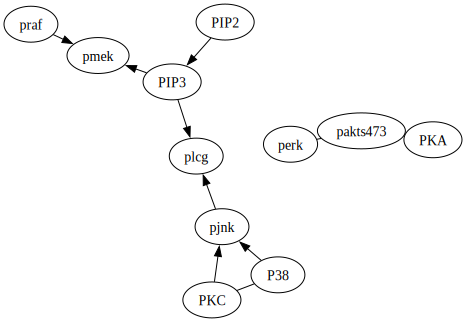

In [49]:
# Your code here (1 point)
tester = IndependenceTester(exp1, 0.1)
A = PC_algorithm(tester)
G = A.run()

graph_to_graphviz(G, tester.node_names)

Now let's look at what else is in the dataset: the interventional data corresponding to different experiments. The PC algorithm did not look at this part of the dataset, but these additional experiments can obviously provide valuable information about the causal graph. In the following questions, we will investigate two examples of this. We will use the output of the PC algorithm that you obtained above to give us a rough idea of what the causal graph might look like. **So don't rerun the algorithm when answering the questions below!**

The interventions in these experiment are not perfect interventions: they change the structural equation of a variable, but not by setting it to a constant. The new structural equation in the intervened model may still include all variables that were there in the original model. So in the graph of the intervened model, all arrows will still be there.

Further, some of the interventions change not one, but multiple structural equations.

For some of the interventions in the data, here is what they do according to many (but not all) experts:
* experiment 5 adds the substance psitectorigenin, which modifies the amount of PIP2;
* experiment 6 adds the substance U0126, which increases the *activity* of pmek. This means that the amount of pmek is not changed by the intervention, but for all *children* of pmek in the causal model, the structural equation changes to reflect that pmek now has a stronger effect on them. pmek is believed to have only one child in the true causal model, namely perk.

(Source: Mooij et al., 2019, specifically Tables 2 & 3 and Figure 35(a))

Create two new dataframes, one containing all data from experiments 1 and 5, and one with the data from experiments 1 and 6. These dataframes should still have an 'experiment' column, so that you can tell for each row whether it came from the observational or the interventional dataset.

In [50]:
exp1and5 = all_data[all_data['experiment'].isin([1,5])]
exp1and6 = all_data[all_data['experiment'].isin([1,6])]
#exp1and5 = exp1and5.drop('experiment', axis=1)
#exp1and6 = exp1and6.drop('experiment', axis=1)
print(exp1and5.shape)
print(exp1and6.shape)
# Your code here (0.5 point)

(1663, 12)
(1652, 12)


**Question (1.5 points)**: In the dataframe for experiments 1 and 5, look at PIP2 and a variable adjacent to it in the output of PC (if there is more than one, pick one). Using about 200 words, answer the following questions:
Based on looking at one or more plots (like scatterplots or histograms), which do you find more likely: that psitectorigenin directly modifies PIP2, or the neighbouring variable, or both? And what does the data for the two experiments seem to say about the direction of the arrow between PIP2 and its neighbour?

Insert one or more markdown and code boxes below here to give your answer and the plots you base your answer on. (Please put your answer in markdown boxes, not as comments in your code!)



In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
filtered_data = exp1and5[exp1and5['experiment'] == 5]
PIP2_exp5 = filtered_data['PIP2']
PIP3_exp5 = filtered_data['PIP3']

filtered_data = exp1and5[exp1and5['experiment'] == 1]
PIP2_exp1 = filtered_data['PIP2']
PIP3_exp1 = filtered_data['PIP3']

PIP2_exp1_norm = (PIP2_exp1-np.mean(PIP2_exp1))/np.std(PIP2_exp1)
PIP2_exp5_norm = (PIP2_exp5-np.mean(PIP2_exp5))/np.std(PIP2_exp5)
PIP3_exp1_norm = (PIP3_exp1-np.mean(PIP3_exp1))/np.std(PIP3_exp1)
PIP3_exp5_norm = (PIP3_exp5-np.mean(PIP3_exp5))/np.std(PIP3_exp5)

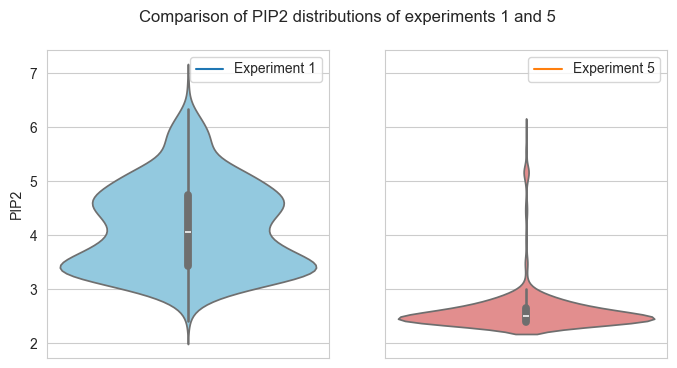

The amount of PIP2 in experiment 1 is : 3541.45
The amount of PIP2 in experiment 5 is : 2113.86


In [52]:
filtered_data = exp1and5[exp1and5['experiment'] == 5]
PIP2_exp5 = filtered_data['PIP2']

filtered_data = exp1and5[exp1and5['experiment'] == 1]
PIP2_exp1 = filtered_data['PIP2']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

# Transpose the violin plots (switch x and y)
sns.violinplot(y=PIP2_exp1, ax=ax1, color='skyblue')
sns.violinplot(y=PIP2_exp5, ax=ax2, color='lightcoral')

#ax1.set_yticks([])  # Set yticks instead of xticks
#ax2.set_yticks([])  # Set yticks instead of xticks
plt.suptitle("Comparison of PIP2 distributions of experiments 1 and 5")
empty_plot, = plt.plot([], [], label='Experiment 1')

# Add the empty plot to the legend
ax1.legend(handles=[empty_plot])
empty_plot, = plt.plot([], [], label='Experiment 5')

# Add the empty plot to the legend
ax2.legend(handles=[empty_plot])
# Customize the legend
#plt.legend(['Experiment 1', 'Experiment 5',])

plt.show()

print(f'The amount of PIP2 in experiment 1 is : {sum(PIP2_exp1):.02f}')
print(f'The amount of PIP2 in experiment 5 is : {sum(PIP2_exp5):.02f}')

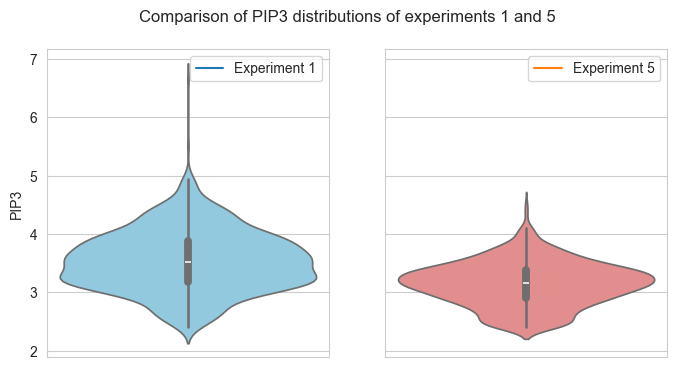

The amount of PIP3 in experiment 1 is : 3022.85
The amount of PIP3 in experiment 5 is : 2549.61


In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

sns.violinplot(y=PIP3_exp1, ax=ax1, color='skyblue')
sns.violinplot(y=PIP3_exp5, ax=ax2, color='lightcoral')

plt.suptitle("Comparison of PIP3 distributions of experiments 1 and 5")

empty_plot, = plt.plot([], [], label='Experiment 1')
ax1.legend(handles=[empty_plot])
empty_plot, = plt.plot([], [], label='Experiment 5')
ax2.legend(handles=[empty_plot])

plt.show()

print(f'The amount of PIP3 in experiment 1 is : {sum(PIP3_exp1):.02f}')
print(f'The amount of PIP3 in experiment 5 is : {sum(PIP3_exp5):.02f}')

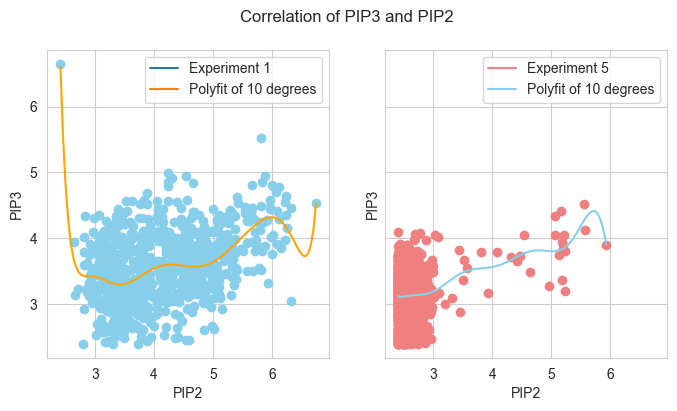

The amount of PIP3 in experiment 1 is : 3022.85
The mean of PIP3 in experiment 1 is : 3.54
The std of PIP3 in experiment 1 is : 0.53
The amount of PIP3 in experiment 5 is : 2549.61
The mean of PIP3 in experiment 5 is : 3.15
The std of PIP3 in experiment 5 is : 0.38
The amount of PIP2 in experiment 1 is : 3541.45
The mean of PIP2 in experiment 1 is : 4.15
The std of PIP2 in experiment 1 is : 0.82
The amount of PIP2 in experiment 5 is : 2113.86
The mean of PIP2 in experiment 5 is : 2.61
The std of PIP2 in experiment 5 is : 0.44


In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.scatter(PIP2_exp1,PIP3_exp1, color='skyblue')
ax2.scatter(PIP2_exp5,PIP3_exp5, color='lightcoral')

plt.suptitle("Correlation of PIP3 and PIP2")

polycounts = 10
empty_plot1, = plt.plot([], [], label='Experiment 1')
empty_plot2, = plt.plot([], [], label=f'Polyfit of {polycounts} degrees')
ax1.legend(handles=[empty_plot1,empty_plot2])
empty_plot1, = plt.plot([], [], label='Experiment 5',c="lightcoral")
empty_plot2, = plt.plot([], [], label=f'Polyfit of {polycounts} degrees',c="skyblue")
ax2.legend(handles=[empty_plot1,empty_plot2])
ax1.set_xlabel("PIP2")
ax1.set_ylabel("PIP3")
ax2.set_xlabel("PIP2")
ax2.set_ylabel("PIP3")

coefficients_exp1 = np.polyfit(PIP2_exp1, PIP3_exp1, polycounts)
coefficients_exp5 = np.polyfit(PIP2_exp5, PIP3_exp5, polycounts)
poly_function_exp1 = np.poly1d(coefficients_exp1)
poly_function_exp5 = np.poly1d(coefficients_exp5)

# Generate x values for the fitted curve
x_fit_exp1 = np.linspace(min(PIP2_exp1), max(PIP2_exp1), 100)
y_fit_exp1 = poly_function_exp1(x_fit_exp1)
x_fit_exp5 = np.linspace(min(PIP2_exp5), max(PIP2_exp5), 100)
y_fit_exp5 = poly_function_exp5(x_fit_exp5)
ax1.plot(x_fit_exp1,y_fit_exp1,c="orange")
ax2.plot(x_fit_exp5,y_fit_exp5,c="skyblue")

plt.show()

print(f'The amount of PIP3 in experiment 1 is : {sum(PIP3_exp1):.02f}')
print(f'The mean of PIP3 in experiment 1 is : {np.mean(PIP3_exp1):.02f}')
print(f'The std of PIP3 in experiment 1 is : {np.std(PIP3_exp1):.02f}')

print(f'The amount of PIP3 in experiment 5 is : {sum(PIP3_exp5):.02f}')
print(f'The mean of PIP3 in experiment 5 is : {np.mean(PIP3_exp5):.02f}')
print(f'The std of PIP3 in experiment 5 is : {np.std(PIP3_exp5):.02f}')

print(f'The amount of PIP2 in experiment 1 is : {sum(PIP2_exp1):.02f}')
print(f'The mean of PIP2 in experiment 1 is : {np.mean(PIP2_exp1):.02f}')
print(f'The std of PIP2 in experiment 1 is : {np.std(PIP2_exp1):.02f}')

print(f'The amount of PIP2 in experiment 5 is : {sum(PIP2_exp5):.02f}')
print(f'The mean of PIP2 in experiment 5 is : {np.mean(PIP2_exp5):.02f}')
print(f'The std of PIP2 in experiment 5 is : {np.std(PIP2_exp5):.02f}')

As we can see from the last scatterplot figure the trends looks the same, mean while the violin-plots show that the distributions have been clearly transformed. For experiment 5 the intervention of psitectorigenin is apparent in the data, the PIP2 ranged from the value of 3 to 6 in the observational data. With the introduction of the chemical in experiment 5 the values have been squeezed mostly between 0 and 3. This observation is clear both in the violin-plots and the scatter-plots. On the other hand PIP3 looks to be marginally affected by this substance, if you look at the violin plots for PIP3. Judging from these results, there is a clear impact on PIP2 and it has been in fact intervened on. This imperfect intervention seems to imply that PIP2 has little influence over PIP3, contrary to what the PC graph would suggest. Driven from our results, we would reverse the direction of the causal edge. If PIP3 is in fact the parent of PIP2, the imperfect intervention made in experiment 5 would show little to no correlation between these variables, since the intervention would sever those edges.

**Question (1.5 points)**: In the dataframe for experiments 1 and 6, look at pmek, perk, and any other variables adjacent to pmek in the output of PC. Assume it is true that adding U0126 produces an intervention on the *activity* of pmek. What would you expect to see in the data if the graph found by PC was correct? Would you propose any changes to that graph based on the data?

Again put your answer (about 200 words) with accompanying plots in new boxes below here.

In [55]:
import matplotlib.pyplot as plt

filtered_data = exp1and6[exp1and6['experiment'] == 6]
pmek_exp6 = filtered_data['pmek']
perk_exp6 = filtered_data['perk']
praf_exp6 = filtered_data['praf']
PIP3_exp6 = filtered_data['PIP3']

filtered_data = exp1and6[exp1and6['experiment'] == 1]
pmek_exp1 = filtered_data['pmek']
perk_exp1 = filtered_data['perk']
praf_exp1 = filtered_data['praf']
PIP3_exp1 = filtered_data['PIP3']


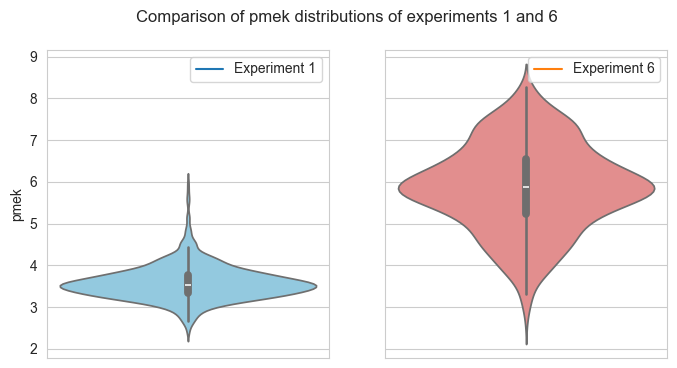

The amount of pmek in experiment 1 is : 3056.14
The amount of pmek in experiment 6 is : 4687.56


In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

variable = "pmek"
exp1 = pmek_exp1
exp6 = pmek_exp6
sns.violinplot(y=exp1, ax=ax1, color='skyblue')
sns.violinplot(y=exp6, ax=ax2, color='lightcoral')

plt.suptitle(f'Comparison of {variable} distributions of experiments 1 and 6')

empty_plot, = plt.plot([], [], label='Experiment 1')
ax1.legend(handles=[empty_plot])
empty_plot, = plt.plot([], [], label='Experiment 6')
ax2.legend(handles=[empty_plot])

plt.show()

print(f'The amount of {variable} in experiment 1 is : {sum(exp1):.02f}')
print(f'The amount of {variable} in experiment 6 is : {sum(exp6):.02f}')

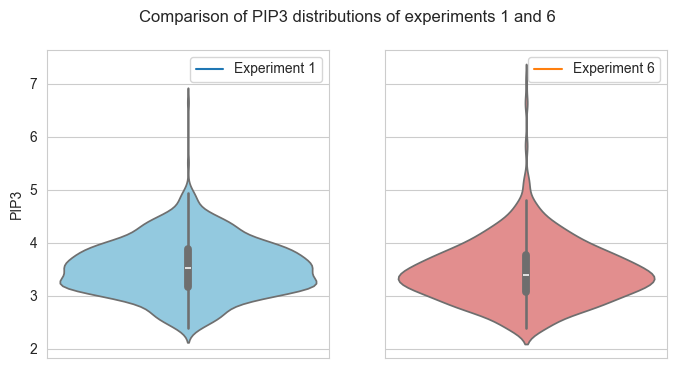

The amount of PIP3 in experiment 1 is : 3022.85
The amount of PIP3 in experiment 6 is : 2764.60


In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

variable = "PIP3"
exp1 = PIP3_exp1
exp6 = PIP3_exp6
sns.violinplot(y=exp1, ax=ax1, color='skyblue')
sns.violinplot(y=exp6, ax=ax2, color='lightcoral')

plt.suptitle(f'Comparison of {variable} distributions of experiments 1 and 6')

empty_plot, = plt.plot([], [], label='Experiment 1')
ax1.legend(handles=[empty_plot])
empty_plot, = plt.plot([], [], label='Experiment 6')
ax2.legend(handles=[empty_plot])

plt.show()

print(f'The amount of {variable} in experiment 1 is : {sum(exp1):.02f}')
print(f'The amount of {variable} in experiment 6 is : {sum(exp6):.02f}')

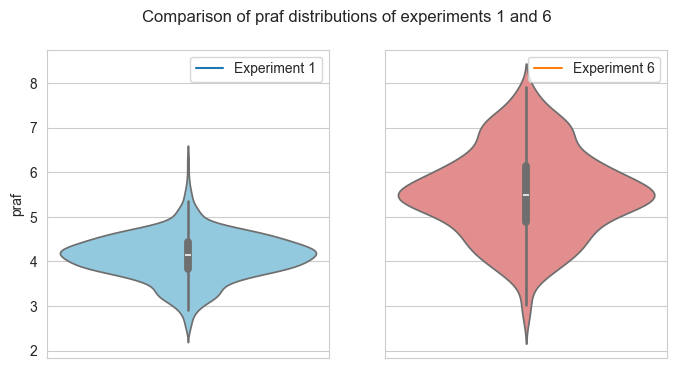

The amount of praf in experiment 1 is : 3503.64
The amount of praf in experiment 6 is : 4410.40


In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

variable = "praf"
exp1 = praf_exp1
exp6 = praf_exp6
sns.violinplot(y=exp1, ax=ax1, color='skyblue')
sns.violinplot(y=exp6, ax=ax2, color='lightcoral')

plt.suptitle(f'Comparison of {variable} distributions of experiments 1 and 6')

empty_plot, = plt.plot([], [], label='Experiment 1')
ax1.legend(handles=[empty_plot])
empty_plot, = plt.plot([], [], label='Experiment 6')
ax2.legend(handles=[empty_plot])

plt.show()

print(f'The amount of {variable} in experiment 1 is : {sum(exp1):.02f}')
print(f'The amount of {variable} in experiment 6 is : {sum(exp6):.02f}')

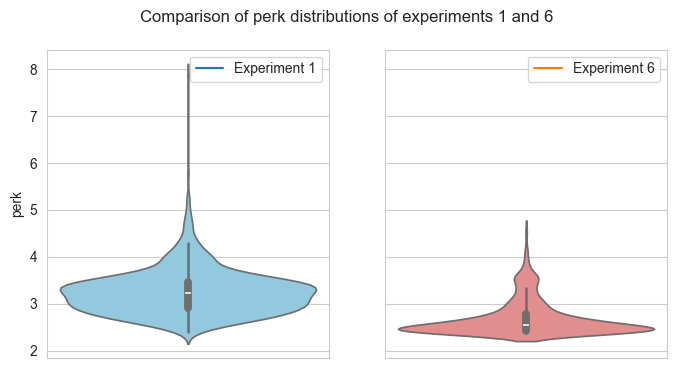

The amount of perk in experiment 1 is : 2770.79
The amount of perk in experiment 6 is : 2146.40
The mean of perk in experiment 1 is : 3.25
The mean of perk in experiment 6 is : 2.69
The std of perk in experiment 1 is : 0.49
The std of perk in experiment 6 is : 0.38


In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

variable = "perk"
exp1 = perk_exp1
exp6 = perk_exp6
sns.violinplot(y=exp1, ax=ax1, color='skyblue')
sns.violinplot(y=exp6, ax=ax2, color='lightcoral')

plt.suptitle(f'Comparison of {variable} distributions of experiments 1 and 6')

empty_plot, = plt.plot([], [], label='Experiment 1')
ax1.legend(handles=[empty_plot])
empty_plot, = plt.plot([], [], label='Experiment 6')
ax2.legend(handles=[empty_plot])

plt.show()

print(f'The amount of {variable} in experiment 1 is : {sum(exp1):.02f}')
print(f'The amount of {variable} in experiment 6 is : {sum(exp6):.02f}')
print(f'The mean of {variable} in experiment 1 is : {np.mean(exp1):.02f}')
print(f'The mean of {variable} in experiment 6 is : {np.mean(exp6):.02f}')
print(f'The std of {variable} in experiment 1 is : {np.std(exp1):.02f}')
print(f'The std of {variable} in experiment 6 is : {np.std(exp6):.02f}')

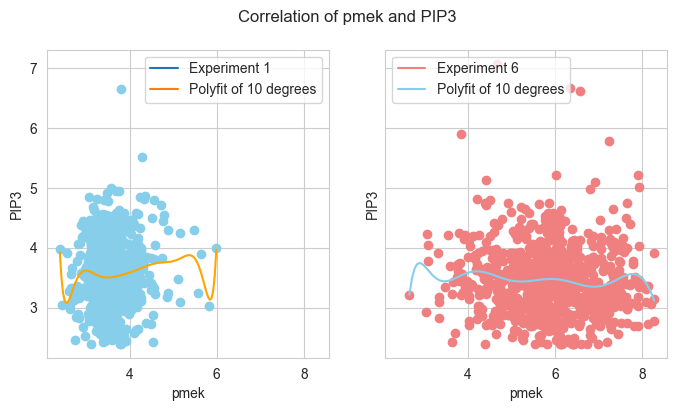

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

variable = "PIP3"
other_exp1 = PIP3_exp1
other_exp6 = PIP3_exp6


ax1.scatter(pmek_exp1,other_exp1, color='skyblue')
ax2.scatter(pmek_exp6,other_exp6, color='lightcoral')

plt.suptitle(f'Correlation of pmek and {variable}')

polycounts = 10
empty_plot1, = plt.plot([], [], label='Experiment 1')
empty_plot2, = plt.plot([], [], label=f'Polyfit of {polycounts} degrees')
ax1.legend(handles=[empty_plot1,empty_plot2])
empty_plot1, = plt.plot([], [], label='Experiment 6',c="lightcoral")
empty_plot2, = plt.plot([], [], label=f'Polyfit of {polycounts} degrees',c="skyblue")
ax2.legend(handles=[empty_plot1,empty_plot2])
ax1.set_xlabel(f'pmek')
ax1.set_ylabel(f'{variable}')
ax2.set_xlabel(f'pmek')
ax2.set_ylabel(f'{variable}')

coefficients_exp1 = np.polyfit(pmek_exp1, other_exp1, polycounts)
coefficients_exp6 = np.polyfit(pmek_exp6, other_exp6, polycounts)
poly_function_exp1 = np.poly1d(coefficients_exp1)
poly_function_exp6 = np.poly1d(coefficients_exp6)

# Generate x values for the fitted curve
x_fit_exp1 = np.linspace(min(pmek_exp1), max(pmek_exp1), 100)
y_fit_exp1 = poly_function_exp1(x_fit_exp1)
x_fit_exp6 = np.linspace(min(pmek_exp6), max(pmek_exp6), 100)
y_fit_exp6 = poly_function_exp6(x_fit_exp6)
ax1.plot(x_fit_exp1,y_fit_exp1,c="orange")
ax2.plot(x_fit_exp6,y_fit_exp6,c="skyblue")

plt.show()

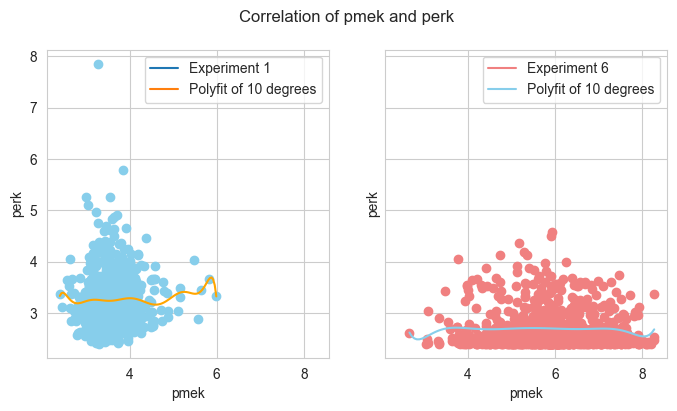

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

variable = "perk"
other_exp1 = perk_exp1
other_exp6 = perk_exp6


ax1.scatter(pmek_exp1,other_exp1, color='skyblue')
ax2.scatter(pmek_exp6,other_exp6, color='lightcoral')

plt.suptitle(f'Correlation of pmek and {variable}')

polycounts = 10
empty_plot1, = plt.plot([], [], label='Experiment 1')
empty_plot2, = plt.plot([], [], label=f'Polyfit of {polycounts} degrees')
ax1.legend(handles=[empty_plot1,empty_plot2])
empty_plot1, = plt.plot([], [], label='Experiment 6',c="lightcoral")
empty_plot2, = plt.plot([], [], label=f'Polyfit of {polycounts} degrees',c="skyblue")
ax2.legend(handles=[empty_plot1,empty_plot2])
ax1.set_xlabel(f'pmek')
ax1.set_ylabel(f'{variable}')
ax2.set_xlabel(f'pmek')
ax2.set_ylabel(f'{variable}')

coefficients_exp1 = np.polyfit(pmek_exp1, other_exp1, polycounts)
coefficients_exp6 = np.polyfit(pmek_exp6, other_exp6, polycounts)
poly_function_exp1 = np.poly1d(coefficients_exp1)
poly_function_exp6 = np.poly1d(coefficients_exp6)

# Generate x values for the fitted curve
x_fit_exp1 = np.linspace(min(pmek_exp1), max(pmek_exp1), 100)
y_fit_exp1 = poly_function_exp1(x_fit_exp1)
x_fit_exp6 = np.linspace(min(pmek_exp6), max(pmek_exp6), 100)
y_fit_exp6 = poly_function_exp6(x_fit_exp6)
ax1.plot(x_fit_exp1,y_fit_exp1,c="orange")
ax2.plot(x_fit_exp6,y_fit_exp6,c="skyblue")

plt.show()

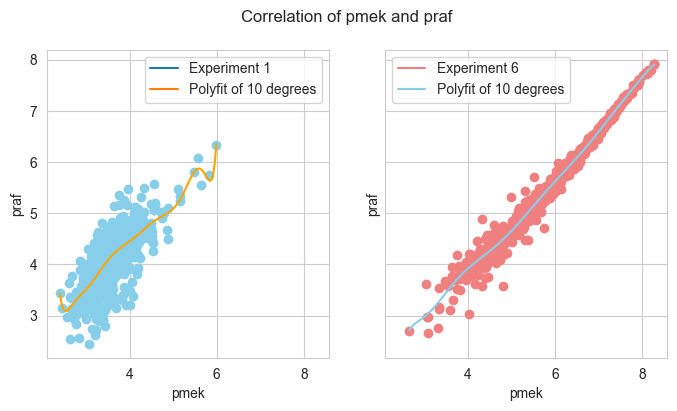

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

variable = "praf"
other_exp1 = praf_exp1
other_exp6 = praf_exp6


ax1.scatter(pmek_exp1,other_exp1, color='skyblue')
ax2.scatter(pmek_exp6,other_exp6, color='lightcoral')

plt.suptitle(f'Correlation of pmek and {variable}')

polycounts = 10
empty_plot1, = plt.plot([], [], label='Experiment 1')
empty_plot2, = plt.plot([], [], label=f'Polyfit of {polycounts} degrees')
ax1.legend(handles=[empty_plot1,empty_plot2])
empty_plot1, = plt.plot([], [], label='Experiment 6',c="lightcoral")
empty_plot2, = plt.plot([], [], label=f'Polyfit of {polycounts} degrees',c="skyblue")
ax2.legend(handles=[empty_plot1,empty_plot2])
ax1.set_xlabel(f'pmek')
ax1.set_ylabel(f'{variable}')
ax2.set_xlabel(f'pmek')
ax2.set_ylabel(f'{variable}')

coefficients_exp1 = np.polyfit(pmek_exp1, other_exp1, polycounts)
coefficients_exp6 = np.polyfit(pmek_exp6, other_exp6, polycounts)
poly_function_exp1 = np.poly1d(coefficients_exp1)
poly_function_exp6 = np.poly1d(coefficients_exp6)

# Generate x values for the fitted curve
x_fit_exp1 = np.linspace(min(pmek_exp1), max(pmek_exp1), 100)
y_fit_exp1 = poly_function_exp1(x_fit_exp1)
x_fit_exp6 = np.linspace(min(pmek_exp6), max(pmek_exp6), 100)
y_fit_exp6 = poly_function_exp6(x_fit_exp6)
ax1.plot(x_fit_exp1,y_fit_exp1,c="orange")
ax2.plot(x_fit_exp6,y_fit_exp6,c="skyblue")

plt.show()

Pmek has been conditionally intervened upon. With reference to the causal graph output by PC we would expect all incoming edges into pmek to be removed with that intervention. Those incoming edges are from PIP3 and praf, after this intervention we expect those proteins to be uncorrelated now. Perk is also assumed to be uncorrelated, only because the PC graph suggests so.

We make the following observations of the seven plots above:
1. From the violin plots of pmek, its observer that the protein has higher values, is more varied and follows a different form of distribution.
2. The before and after violin-plots look identical for the two experiments, suggesting that there is little to no effect between PIP3 and pmek.
3. Praf looks similarly affected as pmek to the intervention, in mean, variance and form.
4. Perk seems to be even more squashed, the mean and variance have been reduced. But not severely.
5. PIP3 seems completely uncorrelated with pmek.
6. Perk seems completely uncorrelated with pmek.
7. Praf seems near perfectly correlated with pmek.

Like we expected, PIP3 shows no sign of correlation and the same goes for perk to the contrary of experts. As a result we propose no changes for these two. For praf there seems to be a near 1 correlation between it and pmek. Given that the intervention would remove the parental edge of praf to pmek we would expect the two substances to be uncorrelated after the intervention. Since this is not the case based on our observations, we suggest that the connection between praf and pmek should be reversed.
For the perk, based on the violin plot comparing it to pmek, there appears to be a negative association with pmek. Although we do not observe a straightforward correlation, the observed dependency suggests the possibility of a non-linear relationship between them.

---

You are almost done! Before handing in, make sure that the code you hand in works, and that all plots are shown. **Submit just one file per team.** Name the submitted file according to your and your collaborator's last name (`submitter_collaborator.ipynb`).

### References
* J. M. Mooij, S. Magliacane, and T. Claassen, "Joint Causal Inference from Multiple Contexts," [arXiv:1611.10351v4](https://arxiv.org/abs/1611.10351), 2019.
* J. Runge, "Conditional Independence Testing Based on a Nearest-Neighbor Estimator of Conditional Mutual Information" In Proceedings of the 21st International Conference on Artificial Intelligence and Statistics, http://proceedings.mlr.press/v84/runge18a.html, 2018.
* K. Sachs, O. Perez, D. Pe’er, D. A. Lauffenburger, and G. P. Nolan, "Causal protein-signaling networks derived from multiparameter single-cell data," Science, vol. 308, no. 5721, pp. 523–529, 2005.